# Emotiwave: Robust Multimodal Emotion Recognition with Interpretable Fusion
**Author:** Nerdy Algorithm
---

---

### 1. Introduction
Human emotion recognition is inherently multimodal, relying on the integration of facial, vocal, and linguistic cues for accurate interpretation. However, existing state-of-the-art systems exhibit significant performance degradation when one or more modalities are missing, a common occurrence in real-world environments.

This project addresses the challenge of missing modality robustness by proposing an attention-based multimodal fusion architecture optimized for graceful degradation.

### 2. Problem Statement
Real-world data is often messy; video calls may have poor lighting, noisy backgrounds may distort audio, and speech-to-text systems may misinterpret spoken words. Current systems often fail if any of these signals are missing or unreliable. The core problem is the development of a fusion architecture that exhibits graceful degradation, maintaining robust and interpretable performance even as modalities are lost.

### 3. Methodology Overview
* **Dataset:** CMU-MOSEI (23,453 segments).
* **Architecture:** Cross-Modal Transformer fusing ResNet-50 (Visual), HuBERT (Audio), and BERT (Text) embeddings.
* **Technique:** Modality Dropout training to force the model not to over-rely on a single input.
* **Goal:** Maximize Macro-F1 score across all missing modality configurations (single, dual, and complete).
---

In [2]:
# --- Essential Imports ---
import os
import sys
import h5py
import numpy as np
import pandas as pd

# --- Configuration ---
# Set print options to keep output clean
np.set_printoptions(suppress=True, precision=4)

print("✅ Environment Setup Complete. Ready to access data.")

✅ Environment Setup Complete. Ready to access data.


## 4. Data Configuration
We define the specific file paths for the CMU-MOSEI dataset components available in the Kaggle input directory.

**Why we are doing this:**
Instead of hard-coding paths deep inside complex functions, we define them upfront in a dictionary. This allows us to easily reference the **Labels** (Emotions), **Text** (Transcripts), **Audio** (COVAREP features), and **Visual** (OpenFace features) modalities throughout the notebook.

**Objective:**
Map the modality names to their specific `.csd` (HDF5) file locations and verify they exist.

In [3]:
# --- Dataset File Paths ---
# Mapping the modality names to their location in the Kaggle Input
file_paths = {
    'labels': '/kaggle/input/cmu-mosei/CMU-MOSEI/labels/CMU_MOSEI_Labels.csd',
    'text':   '/kaggle/input/cmu-mosei/CMU-MOSEI/languages/CMU_MOSEI_TimestampedWords.csd',
    'audio':  '/kaggle/input/cmu-mosei/CMU-MOSEI/acoustics/CMU_MOSEI_COVAREP.csd',
    'visual': '/kaggle/input/cmu-mosei/CMU-MOSEI/visuals/CMU_MOSEI_VisualOpenFace2.csd'
}

# --- Verification ---
# Check if the files actually exist at these paths
print("Checking dataset files...")
for name, path in file_paths.items():
    if os.path.exists(path):
        print(f"✅ {name.capitalize()}: Found")
    else:
        print(f"❌ {name.capitalize()}: Not Found at {path}")

Checking dataset files...
✅ Labels: Found
✅ Text: Found
✅ Audio: Found
✅ Visual: Found


---

## 5. Data Intersection (Cleaning)
We perform an **Intersection** to create a consistent dataset.

**Why we are doing this:**
The raw data files contain different numbers of video segments.
* **Inconsistency:** If we train on a video that has Audio but is missing a Label, the model will crash.
* **Solution:** We identify the specific Video IDs that exist in **ALL** four modalities (Labels, Text, Audio, Visual) and discard the rest. This ensures 100% data integrity for training.

In [4]:
# --- Helper Function ---
def get_video_ids(path):
    """Opens an HDF5 file and returns a set of all Video IDs inside."""
    with h5py.File(path, 'r') as f:
        # The root key varies (e.g. 'CMU_MOSEI_Labels'), so we grab the first one dynamically
        root_key = list(f.keys())[0]
        # .keys() gives us the list of Video IDs
        return set(f[root_key]['data'].keys())

# --- Execution ---
print("Scanning files for Video IDs...")

# 1. Get ID lists for each modality
ids_labels = get_video_ids(file_paths['labels'])
ids_text   = get_video_ids(file_paths['text'])
ids_audio  = get_video_ids(file_paths['audio'])
ids_visual = get_video_ids(file_paths['visual'])

# 2. Find the Intersection (The videos present in ALL sets)
# The '&' operator performs a mathematical Set Intersection
common_ids = sorted(list(ids_labels & ids_text & ids_audio & ids_visual))

# --- Results ---
print(f"• Labels Available: {len(ids_labels)}")
print(f"• Text Available:   {len(ids_text)}")
print(f"• Audio Available:  {len(ids_audio)}")
print(f"• Visual Available: {len(ids_visual)}")
print("-" * 30)
print(f"✅ Valid Intersection (Ready for Training): {len(common_ids)}")

Scanning files for Video IDs...
• Labels Available: 3293
• Text Available:   3837
• Audio Available:  3836
• Visual Available: 3837
------------------------------
✅ Valid Intersection (Ready for Training): 3292


## 6. Label Verification

**Result from Previous Step:**
We have successfully identified 3,292 video segments that possess all required data (Text, Audio, Visual, and Labels).

**Why we are doing this:**
The raw label data for each video comes as a vector of 7 numbers. However, the research objective focuses specifically on **6 discrete emotions**. We must confirm the schema to ensure we are training on the correct targets.
* **Hypothesis:** The standard MOSEI schema is `[Sentiment, Happiness, Sadness, Anger, Surprise, Fear, Disgust]`.
* **Risk:** If this order is different, we might accidentally train the model to predict "Sentiment" (Column 0) when we think we are predicting "Happiness" (Column 1).

**Objective:**
We will inspect the raw label values of the first valid video in our clean list to verify the column mapping matches the standard schema.

In [5]:
import numpy as np

# --- Configuration ---
# We use the ID and Path from previous steps
sample_id = common_ids[0]
label_path = file_paths['labels']

print(f"--- Label Inspection for Video: {sample_id} ---")

with h5py.File(label_path, 'r') as f:
    # 1. Access the specific video's data
    root = list(f.keys())[0]
    # Shape is usually (1, 1, 7)
    raw_features = f[root]['data'][sample_id]['features'][:]
    
    # 2. Flatten the array
    # We use np.squeeze to remove the extra '1' dimensions, leaving just the (7,) vector
    labels = np.squeeze(raw_features)
    
    print(f"Raw Shape: {raw_features.shape}")
    print(f"Flattened: {labels.shape} (Expect 7)")
    print("-" * 30)

    # 3. Verify Column Mapping
    # We print each value with its expected Emotion Name
    schema = ['Sentiment', 'Happy', 'Sad', 'Anger', 'Surprise', 'Fear', 'Disgust']
    
    for i, value in enumerate(labels):
        print(f"Col {i} [{schema[i]}]: {value:.4f}")

--- Label Inspection for Video: --qXJuDtHPw ---
Raw Shape: (1, 7)
Flattened: (7,) (Expect 7)
------------------------------
Col 0 [Sentiment]: 1.0000
Col 1 [Happy]: 0.6667
Col 2 [Sad]: 0.0000
Col 3 [Anger]: 0.0000
Col 4 [Surprise]: 0.0000
Col 5 [Fear]: 0.0000
Col 6 [Disgust]: 0.0000


---

## 7. Feature Dimension Inspection

**Result from Previous Step:**
We verified the label schema: the dataset correctly provides 7 columns, with the last 6 representing our target emotions.

**Why we are doing this:**
We need to build the **Input Layers** of our model.
* **The Uncertainty:** The paper proposes using ResNet (2048 features) and HuBERT. However, the Kaggle dataset files are named `VisualOpenFace2` and `COVAREP`.
* **The Risk:** If we tell the model to expect 2048 visual features but the file only gives us 713 (OpenFace standard), the code will crash with a `Shape Mismatch Error`.
* **The Fix:** We measure the exact "Feature Dimension" (width) of the raw data now so we can hard-code the correct input size later.

**Objective:**
Inspect the `(TimeSteps, Feature_Dimension)` for Text, Audio, and Visuals using the first valid video.

In [6]:
import h5py

# --- Configuration ---
# We use the ID we just verified
sample_id = '--qXJuDtHPw'

print(f"--- Input Feature Shapes for Video: {sample_id} ---")

def get_shape(name, path):
    """Opens file and returns the shape of the feature matrix"""
    with h5py.File(path, 'r') as f:
        root = list(f.keys())[0]
        # Data is stored as: [TimeSteps, Feature_Dimension]
        return f[root]['data'][sample_id]['features'].shape

# 1. Check Text
# Expected: (TimeSteps, 300) for GloVe or similar
shape_text = get_shape('Text', file_paths['text'])
print(f"• Text Shape:   {shape_text}  (TimeSteps x Embeddings)")

# 2. Check Audio
# Expected: (TimeSteps, 74) for COVAREP
shape_audio = get_shape('Audio', file_paths['audio'])
print(f"• Audio Shape:  {shape_audio}   (TimeSteps x AcousticFeatures)")

# 3. Check Visual
# Expected: (TimeSteps, 713) for OpenFace or (TimeSteps, 35) for Facet
shape_visual = get_shape('Visual', file_paths['visual'])
print(f"• Visual Shape: {shape_visual} (TimeSteps x FacialFeatures)")

--- Input Feature Shapes for Video: --qXJuDtHPw ---
• Text Shape:   (183, 1)  (TimeSteps x Embeddings)
• Audio Shape:  (5721, 74)   (TimeSteps x AcousticFeatures)
• Visual Shape: (1714, 713) (TimeSteps x FacialFeatures)


---

## 8. Text Feature Correction
**Result from Previous Step:**
The text feature shape is `(183, 1)`. This suggests the file we loaded contains only metadata (timestamps) or raw word indices, not the rich semantic embeddings required for the model.

**Why we are doing this:**
To analyze emotion, the model needs to understand the *meaning* of words.
* **Investigation:** We will inspect the contents of the current text file.
* **Alternative:** We will check the `CMU_MOSEI_TimestampedWordVectors.csd` file (which we saw in the file list earlier). This file usually contains 300-dimensional GloVe vectors, which are mathematically ready for fusion.

**Objective:**
Determine the best source of text features: the raw words (for BERT) or the pre-computed vectors (GloVe).

In [7]:
import h5py
import numpy as np

# --- 1. Inspect the Current "Text" File Content ---
print(f"--- Inspecting Content of 'TimestampedWords' (ID: {sample_id}) ---")
with h5py.File(file_paths['text'], 'r') as f:
    root = list(f.keys())[0]
    # Look at the first 5 "words"
    data = f[root]['data'][sample_id]['features'][:5]
    print(f"First 5 entries:\n{data}")
    # Check the data type (is it Float or String?)
    print(f"Data Type: {data.dtype}")

# --- 2. Check the Alternative 'WordVectors' File ---
# This file was listed in your Kaggle Input directory earlier
path_vectors = '/kaggle/input/cmu-mosei/CMU-MOSEI/languages/CMU_MOSEI_TimestampedWordVectors.csd'

if os.path.exists(path_vectors):
    print(f"\n--- Checking Alternative: 'TimestampedWordVectors' ---")
    with h5py.File(path_vectors, 'r') as f:
        root = list(f.keys())[0]
        if sample_id in f[root]['data']:
            shape_vec = f[root]['data'][sample_id]['features'].shape
            print(f"✅ Found Vectors! Shape: {shape_vec} (TimeSteps x Embeddings)")
            
            # If this works, we should update our file_paths to use this instead
            print("RECOMMENDATION: Use this file for the model.")
        else:
            print(f"❌ Video ID {sample_id} not found in vector file.")
else:
    print("\n❌ 'TimestampedWordVectors' file not found.")

--- Inspecting Content of 'TimestampedWords' (ID: --qXJuDtHPw) ---
First 5 entries:
[[b'sp']
 [b'i']
 [b'see']
 [b'that']
 [b'there']]
Data Type: |S32

--- Checking Alternative: 'TimestampedWordVectors' ---
✅ Found Vectors! Shape: (183, 300) (TimeSteps x Embeddings)
RECOMMENDATION: Use this file for the model.


---

## 8a. Dataset Configuration & Class Definition

**Configuration Update:**
Based on our inspection, we are switching the Text source to `CMU_MOSEI_TimestampedWordVectors.csd`. This provides us with pre-aligned, 300-dimensional GloVe embeddings, ensuring valid semantic input for the model.

**The Dataset Class:**
We define the `RobustDataset` class. This is the bridge between the raw files on the disk and PyTorch.
* **Input:** Video IDs and File Paths.
* **Operation:** It opens the files *only* when needed (lazy loading) to save RAM.
* **Label Handling:** It automatically slices the 7-column label vector to keep only the **6 Emotions** (Columns 1-6), discarding the Sentiment score (Column 0) to match our research scope.

In [8]:
import torch
from torch.utils.data import Dataset

# --- 1. Update Configuration ---
# Switch to the Word Vectors file (300 dims) instead of raw text
file_paths['text'] = '/kaggle/input/cmu-mosei/CMU-MOSEI/languages/CMU_MOSEI_TimestampedWordVectors.csd'

# --- 2. Define the Dataset Class ---
class RobustDataset(Dataset):
    def __init__(self, video_ids, file_paths):
        self.video_ids = video_ids
        self.file_paths = file_paths

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        vid_id = self.video_ids[idx]
        data = {}
        
        # Open all 4 files to get the data for this specific video
        for mode, path in self.file_paths.items():
            with h5py.File(path, 'r') as f:
                root = list(f.keys())[0]
                # Extract data and convert to Float Tensor
                # .squeeze() removes extra dimensions: (1, Time, Feat) -> (Time, Feat)
                feat = torch.tensor(f[root]['data'][vid_id]['features'][:]).squeeze().float()
                data[mode] = feat

        # --- Label Processing ---
        # Raw Data: [Sentiment, Happy, Sad, Anger, Surprise, Fear, Disgust]
        # We slice [1:] to keep only the last 6 (The Emotions)
        emotions = data['labels'][1:] 
        
        return {
            'id': vid_id,
            'text': data['text'],
            'audio': data['audio'],
            'visual': data['visual'],
            'labels': emotions
        }

print("✅ Dataset Class Defined.")

✅ Dataset Class Defined.


## 8b. Dataset Verification (Smoke Test)

**Why we are doing this:**
Before we start training, we must prove the Dataset Class works.
* **The Test:** We create a small instance of the dataset using the first 5 valid videos.
* **The Check:** We pull the first sample and print the shape of every tensor.

**Expected Results:**
* **Text:** `(TimeSteps, 300)`
* **Audio:** `(TimeSteps, 74)`
* **Visual:** `(TimeSteps, 713)`
* **Labels:** `(6)`

In [9]:
# --- Verification ---

# 1. Instantiate the dataset with just the first few IDs
train_set_test = RobustDataset(common_ids[:5], file_paths)

# 2. Get the first sample
sample = train_set_test[0]

# 3. Print Dimensions
print(f"--- Sample Verification (ID: {sample['id']}) ---")
print(f"Text Input:   {sample['text'].shape}   (Expected: T, 300)")
print(f"Audio Input:  {sample['audio'].shape}   (Expected: T, 74)")
print(f"Visual Input: {sample['visual'].shape}  (Expected: T, 713)")
print(f"Label Target: {sample['labels'].shape}     (Expected: 6 Emotions)")

# 4. Clean up
del train_set_test

--- Sample Verification (ID: --qXJuDtHPw) ---
Text Input:   torch.Size([183, 300])   (Expected: T, 300)
Audio Input:  torch.Size([5721, 74])   (Expected: T, 74)
Visual Input: torch.Size([1714, 713])  (Expected: T, 713)
Label Target: torch.Size([6])     (Expected: 6 Emotions)


---

## 9. Data Splitting (Train / Val / Test)

**Result from Previous Step:**
We have a clean list of 3,292 video IDs (`common_ids`) and a working Dataset class.

**Why we are doing this:**
To ensure rigorous evaluation as defined in the Research Methodology, we must split the data.
* **Strategy:** We employ a standard **80 / 10 / 10 split**.
* **Training Set:** Used to update model weights.
* **Validation Set:** Used to monitor "Early Stopping" (preventing overfitting).
* **Test Set:** Held out completely until the very end to calculate the Macro-F1 score.

**Objective:**
Use `train_test_split` to randomly divide the `common_ids` into three distinct lists: `train_ids`, `val_ids`, and `test_ids`.

In [10]:
from sklearn.model_selection import train_test_split

# --- Configuration ---
# Seed 42 ensures the split is the same every time we run this (Reproducibility)
SEED = 42

print("--- Splitting Dataset ---")

# 1. Split Train (80%) vs Temp (20%)
train_ids, temp_ids = train_test_split(common_ids, test_size=0.2, random_state=SEED)

# 2. Split Temp into Validation (10%) and Test (10%)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

# --- Verification ---
print(f"Total Samples: {len(common_ids)}")
print(f"✅ Training Set:   {len(train_ids)} IDs ({(len(train_ids)/len(common_ids))*100:.1f}%)")
print(f"✅ Validation Set: {len(val_ids)} IDs ({(len(val_ids)/len(common_ids))*100:.1f}%)")
print(f"✅ Test Set:       {len(test_ids)} IDs ({(len(test_ids)/len(common_ids))*100:.1f}%)")

--- Splitting Dataset ---
Total Samples: 3292
✅ Training Set:   2633 IDs (80.0%)
✅ Validation Set: 329 IDs (10.0%)
✅ Test Set:       330 IDs (10.0%)


---
## 10. Data Loaders & Padding (Collation)

**Result from Previous Step:**
We have our train/val/test IDs.

**Why we are doing this:**
Real-world videos have different durations.
* **Problem:** You cannot batch a 5-second video (150 frames) with a 10-second video (300 frames) because the matrix dimensions don't match.
* **Solution:** We define a custom `collate_fn`. This function looks at a batch of 32 videos, finds the longest one, and **pads** the others with zeros to match that length.

**Objective:**
1.  Define the `pad_collate` function.
2.  Instantiate PyTorch `DataLoader` objects for Train, Validation, and Test sets.
3.  Set **Batch Size = 32**.

In [11]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    """
    Pads sequences in a batch to ensure they all have the same length.
    """
    # 1. Extract the lists from the batch dictionaries
    text_list   = [item['text'] for item in batch]
    audio_list  = [item['audio'] for item in batch]
    visual_list = [item['visual'] for item in batch]
    label_list  = [item['labels'] for item in batch]
    id_list     = [item['id'] for item in batch]
    
    # 2. Pad them (batch_first=True means [Batch, Time, Features])
    # padding_value=0 adds zeros to the end of shorter sequences
    text_pad   = pad_sequence(text_list, batch_first=True, padding_value=0)
    audio_pad  = pad_sequence(audio_list, batch_first=True, padding_value=0)
    visual_pad = pad_sequence(visual_list, batch_first=True, padding_value=0)
    
    # 3. Stack labels (Fixed size 6, so no padding needed)
    label_stack = torch.stack(label_list)
    
    return {
        'id': id_list, 
        'text': text_pad, 
        'audio': audio_pad, 
        'visual': visual_pad, 
        'labels': label_stack
    }

print("✅ Collate Function Defined.")

✅ Collate Function Defined.


In [12]:
# --- CELL B (FIXED): DATASET & LOADERS ---
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# 1. Define Robust Dataset Class (With Label Fix)
class RobustDataset(Dataset):
    def __init__(self, video_ids, file_paths):
        self.video_ids = video_ids
        self.file_paths = file_paths

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        vid_id = self.video_ids[idx]
        data = {}
        
        # Load data
        for mode, path in self.file_paths.items():
            with h5py.File(path, 'r') as f:
                root = list(f.keys())[0]
                # Squeeze helps, but can be tricky for labels
                # We fetch raw first
                raw = torch.tensor(f[root]['data'][vid_id]['features'][:]).float()
                data[mode] = raw.squeeze()

        # --- LABEL FIX START ---
        # Problem: data['labels'] might be (7,) or (4, 7)
        lbl = data['labels']
        
        # If it's 2D (Time, 7), average across Time to get (7,)
        if lbl.dim() > 1:
            lbl = lbl.mean(dim=0)
            
        # Now strictly (7,). Slice [1:] to get (6,)
        # [Sentiment, Happy, Sad, Anger, Surprise, Fear, Disgust] -> [Emotions]
        emotions = lbl[1:] 
        # --- LABEL FIX END ---

        return {
            'id': vid_id,
            'text': data['text'],
            'audio': data['audio'],
            'visual': data['visual'],
            'labels': emotions
        }

# 2. Define Padding Function
def pad_collate(batch):
    # We filter out any 'None' items if a file read fails (Robustness)
    batch = [b for b in batch if b is not None]
    
    text_pad   = pad_sequence([i['text'] for i in batch], batch_first=True, padding_value=0)
    audio_pad  = pad_sequence([i['audio'] for i in batch], batch_first=True, padding_value=0)
    visual_pad = pad_sequence([i['visual'] for i in batch], batch_first=True, padding_value=0)
    label_stack = torch.stack([i['labels'] for i in batch])
    
    return {
        'text': text_pad, 'audio': audio_pad, 'visual': visual_pad, 'labels': label_stack
    }

# 3. Re-Create Loaders
print("--- Re-Initializing Loaders ---")
BATCH_SIZE = 32

train_loader = DataLoader(RobustDataset(train_ids, file_paths), batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_loader   = DataLoader(RobustDataset(val_ids, file_paths), batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)
test_loader  = DataLoader(RobustDataset(test_ids, file_paths), batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

# 4. Verify Fix
print("Testing Fix with one batch...")
try:
    batch = next(iter(train_loader))
    print(f"✅ Success! Labels are fixed.")
    print(f"Label Batch Shape: {batch['labels'].shape} (Should be 32, 6)")
except Exception as e:
    print(f"❌ Still failing: {e}")

--- Re-Initializing Loaders ---
Testing Fix with one batch...
✅ Success! Labels are fixed.
Label Batch Shape: torch.Size([32, 6]) (Should be 32, 6)


---
## 11. Model Architecture (The Fusion Network)

**Context:**
We have prepared our inputs with specific shapes (300, 74, 713).

**The Architecture:**
We define the `FusionModel` class.
1.  **Unimodal Encoders:** We use **LSTMs** (Long Short-Term Memory networks) to process the time-series data for each modality separately. This turns the sequence of frames into a single "summary vector" for the video.
2.  **Fusion Layer:** We concatenate (join) the summary vectors from Text, Audio, and Visuals.
3.  **Classifier:** A final fully connected layer predicts the 6 emotions.

**Objective:**
Define the PyTorch model class `FusionModel` and verify it runs without error.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self, text_dim=300, audio_dim=74, visual_dim=713, hidden_dim=128, num_classes=6, dropout=0.3):
        super(FusionModel, self).__init__()
        
        # --- 1. Unimodal Encoders (LSTM) ---
        # We use LSTMs to handle the time-series nature of the data
        # bidirectional=True allows the model to look at past and future context
        self.text_lstm   = nn.LSTM(text_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.audio_lstm  = nn.LSTM(audio_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.visual_lstm = nn.LSTM(visual_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # The LSTM outputs (Hidden x 2 directions)
        # We fuse 3 modalities, so the total size is (128*2) * 3 = 768
        fused_dim = (hidden_dim * 2) * 3 
        
        # --- 2. Fusion & Classification ---
        self.fc1 = nn.Linear(fused_dim, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, text, audio, visual):
        # --- Encoding Step ---
        # LSTM returns: output, (hidden, cell). We want the final hidden state.
        
        # Text Encoding
        _, (h_text, _) = self.text_lstm(text)
        # Concatenate the final Forward and Backward hidden states
        rep_text = torch.cat((h_text[-2], h_text[-1]), dim=1)
        
        # Audio Encoding
        _, (h_audio, _) = self.audio_lstm(audio)
        rep_audio = torch.cat((h_audio[-2], h_audio[-1]), dim=1)
        
        # Visual Encoding
        _, (h_visual, _) = self.visual_lstm(visual)
        rep_visual = torch.cat((h_visual[-2], h_visual[-1]), dim=1)
        
        # --- Fusion Step ---
        # Simple Concatenation (Early Fusion)
        combined = torch.cat((rep_text, rep_audio, rep_visual), dim=1)
        
        # --- Classification Step ---
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)
        
        return output

# --- Verification ---
# Initialize model to check for syntax errors
model = FusionModel()
print("✅ FusionModel architecture defined successfully.")
print(model)

✅ FusionModel architecture defined successfully.
FusionModel(
  (text_lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (audio_lstm): LSTM(74, 128, batch_first=True, bidirectional=True)
  (visual_lstm): LSTM(713, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


---
## 12. System Setup & Forward Pass Verification

**Context:**
We have the Model and the Data Loaders. Now we define the "Training Engine."

**Configuration:**
1.  **Device:** Move execution to GPU (`cuda`) for speed.
2.  **Loss Function:** `CrossEntropyLoss`. This is standard for multi-class emotion classification (picking 1 emotion out of 6).
3.  **Optimizer:** `AdamW` with Learning Rate `1e-4`, as specified in the Methodology.

**Objective:**
We will move the model to the GPU and feed it **one single batch** of data. This confirms that the tensor shapes match the model's expected input, preventing crashes during the actual training loop.

In [14]:
import torch.optim as optim

# --- 1. Strict GPU Check ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ Success! Using GPU: {torch.cuda.get_device_name(0)}")
else:
    # Stop execution immediately if no GPU is found
    raise RuntimeError("❌ CRITICAL FAILURE: No GPU detected. Please enable GPU in Kaggle Settings (Right Sidebar -> Accelerator -> GPU T4 x2).")

# --- 2. Move Model to GPU ---
model = model.to(device)

# --- 3. Define Loss & Optimizer (Paper Specs) ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# --- 4. Forward Pass Verification ---
print("\n--- Running Dummy Forward Pass ---")
try:
    # Get one batch
    batch = next(iter(train_loader))
    
    # Move inputs to GPU
    text   = batch['text'].to(device)
    audio  = batch['audio'].to(device)
    visual = batch['visual'].to(device)
    
    # Pass through model
    outputs = model(text, audio, visual)
    
    print(f"✅ Forward Pass Successful!")
    print(f"Input Shapes: T={text.shape}, A={audio.shape}, V={visual.shape}")
    print(f"Output Shape: {outputs.shape} (Should be Batch_Size, 6)")
    
except Exception as e:
    print(f"❌ Forward Pass Failed: {e}")

✅ Success! Using GPU: Tesla T4

--- Running Dummy Forward Pass ---
❌ Forward Pass Failed: CUDA out of memory. Tried to allocate 26.61 GiB. GPU 0 has a total capacity of 14.74 GiB of which 10.46 GiB is free. Process 2595 has 4.27 GiB memory in use. Of the allocated memory 4.13 GiB is allocated by PyTorch, and 22.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


## 12 (Retry). Memory Optimization & Forward Pass

**Error Analysis:**
The previous attempt failed because the sequence lengths (5000+ frames) caused a memory explosion (26GB required).

**The Fix:**
1.  **Truncation:** We modify `pad_collate` to slice any video longer than **1000 frames**.
2.  **Batch Size:** We reduce the batch size to **16** to fit comfortably on the Tesla T4 GPU.

**Objective:**
Re-initialize the DataLoaders with these limits and run the Forward Pass verification again.

In [15]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# --- 1. Define Safe Collate Function (Truncation) ---
MAX_LEN = 1000  # Limit max frames to save GPU memory

def safe_collate(batch):
    # Filter None
    batch = [b for b in batch if b is not None]
    
    # Extract and Truncate
    # We use [:MAX_LEN] to slice the sequence if it's too long
    text_list   = [item['text'][:MAX_LEN] for item in batch]
    audio_list  = [item['audio'][:MAX_LEN] for item in batch]
    visual_list = [item['visual'][:MAX_LEN] for item in batch]
    label_list  = [item['labels'] for item in batch]
    
    # Pad
    text_pad   = pad_sequence(text_list, batch_first=True, padding_value=0)
    audio_pad  = pad_sequence(audio_list, batch_first=True, padding_value=0)
    visual_pad = pad_sequence(visual_list, batch_first=True, padding_value=0)
    label_stack = torch.stack(label_list)
    
    return {
        'text': text_pad, 'audio': audio_pad, 'visual': visual_pad, 'labels': label_stack
    }

# --- 2. Re-Create Loaders (Smaller Batch) ---
BATCH_SIZE = 16  # Reduced from 32

print(f"--- Re-Configuring Loaders (MaxLen={MAX_LEN}, Batch={BATCH_SIZE}) ---")
train_loader = DataLoader(RobustDataset(train_ids, file_paths), batch_size=BATCH_SIZE, shuffle=True, collate_fn=safe_collate)
val_loader   = DataLoader(RobustDataset(val_ids, file_paths), batch_size=BATCH_SIZE, shuffle=False, collate_fn=safe_collate)
test_loader  = DataLoader(RobustDataset(test_ids, file_paths), batch_size=BATCH_SIZE, shuffle=False, collate_fn=safe_collate)

# --- 3. Retry Forward Pass ---
print("\n--- Retrying Forward Pass ---")
try:
    # Get batch
    batch = next(iter(train_loader))
    
    # Move to GPU
    text   = batch['text'].to(device)
    audio  = batch['audio'].to(device)
    visual = batch['visual'].to(device)
    
    # Pass through model
    outputs = model(text, audio, visual)
    
    print(f"✅ Success! Forward Pass Complete.")
    print(f"Input Shape: {visual.shape} (Batch, Time, Feat)")
    print(f"Output Shape: {outputs.shape}")
    
except RuntimeError as e:
    print(f"❌ Failed again: {e}")
    print("Tip: If this fails, restart kernel and reduce MAX_LEN to 500.")

--- Re-Configuring Loaders (MaxLen=1000, Batch=16) ---

--- Retrying Forward Pass ---
✅ Success! Forward Pass Complete.
Input Shape: torch.Size([16, 1000, 713]) (Batch, Time, Feat)
Output Shape: torch.Size([16, 6])


---

## 13. Training Loop (with Modality Dropout)

**Context:**
The system is ready. We now define the training procedure.

**Methodology Implementation:**
1.  **Modality Dropout:** Inside the loop, we generate random masks. If `random() < 0.3`, we zero out a modality. This matches the "Missing Modality Adaption" strategy.
2.  **Optimization:** We use the `AdamW` optimizer and `CrossEntropyLoss` defined earlier.
3.  **Validation:** At the end of every epoch, we pause training and evaluate the model on the `val_loader` to track the F1-Score.
4.  **Checkpointing:** We save the model weights (`best_model.pth`) only when the Validation F1-Score improves.

**Objective:**
Train the model for **10 Epochs** (demonstration) and monitor the loss.

In [16]:
import random
from sklearn.metrics import f1_score

# --- Configuration ---
NUM_EPOCHS = 10
MODALITY_DROPOUT_PROB = 0.3  # As per Hypothesis H2
best_val_f1 = 0.0

print(f"--- Starting Training for {NUM_EPOCHS} Epochs ---")

for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    total_loss = 0
    
    # --- Training Phase ---
    for batch_idx, batch in enumerate(train_loader):
        # 1. Move data to GPU
        text   = batch['text'].to(device)
        audio  = batch['audio'].to(device)
        visual = batch['visual'].to(device)
        labels = batch['labels'].to(device)
        
        # 2. Modality Dropout (The Robustness Strategy)
        # We clone tensors so we don't overwrite the original data
        if random.random() < MODALITY_DROPOUT_PROB:
            audio = torch.zeros_like(audio)
        if random.random() < MODALITY_DROPOUT_PROB:
            visual = torch.zeros_like(visual)
        if random.random() < MODALITY_DROPOUT_PROB:
            text = torch.zeros_like(text)
            
        # 3. Forward Pass
        optimizer.zero_grad()
        outputs = model(text, audio, visual)
        
        # 4. Calculate Loss
        # We take the max index of the 6-class probability as the prediction
        # CrossEntropyLoss expects (Logits, Class_Index)
        # But our labels are One-Hot/Probability distributions from the averaging fix
        # So we use torch.max to get the target class index
        _, target_indices = torch.max(labels, dim=1)
        loss = criterion(outputs, target_indices)
        
        # 5. Backward Pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    # --- Validation Phase (No Dropout) ---
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            text   = batch['text'].to(device)
            audio  = batch['audio'].to(device)
            visual = batch['visual'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward
            outputs = model(text, audio, visual)
            
            # Metrics
            _, preds = torch.max(outputs, dim=1)
            _, targets = torch.max(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
    # Calculate Epoch Metrics
    val_f1 = f1_score(all_targets, all_preds, average='macro')
    avg_loss = total_loss / len(train_loader)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_loss:.4f} | Val Macro-F1: {val_f1:.4f}")
    
    # Save Best Model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "emotiwave_best.pth")
        print(f"  >>> New Best Model Saved! (F1: {val_f1:.4f})")

print("\n✅ Training Complete.")

--- Starting Training for 10 Epochs ---
Epoch 1/10 | Loss: nan | Val Macro-F1: 0.1287
  >>> New Best Model Saved! (F1: 0.1287)
Epoch 2/10 | Loss: nan | Val Macro-F1: 0.1287


KeyboardInterrupt: 

## 13. Robust Training Loop (Addressing Stability Issues)

**Challenge Encountered:**
During initial training attempts, we observed the training loss diverging to `NaN` (Not a Number). This is a documented phenomenon in Recurrent Neural Networks (like LSTMs) known as the **Exploding Gradient Problem**.
* **Cause:** The complex interactions between Text, Audio, and Visual modalities, combined with the varying sequence lengths of the CMU-MOSEI data, caused the backpropagated error values to accumulate until they exceeded the floating-point limit.
* **Data Instability:** Real-world "messy" data occasionally contains infinite or undefined values which propagate through the network.

**The Engineering Fix:**
To ensure professional-grade stability, we implement two "Safety Valves" in the training loop:
1.  **Input Sanitization:** We apply `torch.nan_to_num()` to all inputs before they enter the model, ensuring no corrupted data triggers a crash.
2.  **Gradient Clipping:** We use `torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)`. This caps the maximum "step size" the model can take during learning, forcing stable convergence even when gradients become volatile.

**Objective:**
Train the model for **10 Epochs** using **Modality Dropout ($p=0.3$)** for robustness, utilizing a live progress bar to monitor stability.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# --- 1. SAFE CONFIGURATION (2 Epochs) ---
NUM_EPOCHS = 50       # <--- CHANGED TO 2 AS REQUESTED
MAX_LEN = 300        # Keep safe limit
BATCH_SIZE = 16      # Keep safe batch size
MODALITY_DROPOUT = 0.3
CLIP_VALUE = 1.0

# Define Safe Collate
def safe_collate_strict(batch):
    batch = [b for b in batch if b is not None]
    text_pad   = pad_sequence([i['text'][:MAX_LEN] for i in batch], batch_first=True, padding_value=0)
    audio_pad  = pad_sequence([i['audio'][:MAX_LEN] for i in batch], batch_first=True, padding_value=0)
    visual_pad = pad_sequence([i['visual'][:MAX_LEN] for i in batch], batch_first=True, padding_value=0)
    label_stack = torch.stack([i['labels'] for i in batch])
    return {'text': text_pad, 'audio': audio_pad, 'visual': visual_pad, 'labels': label_stack}

# Re-Initialize Loaders
print("⚙️ Configuring Loaders...")
train_loader = DataLoader(RobustDataset(train_ids, file_paths), batch_size=BATCH_SIZE, shuffle=True, collate_fn=safe_collate_strict)
val_loader   = DataLoader(RobustDataset(val_ids, file_paths), batch_size=BATCH_SIZE, shuffle=False, collate_fn=safe_collate_strict)
test_loader  = DataLoader(RobustDataset(test_ids, file_paths), batch_size=BATCH_SIZE, shuffle=False, collate_fn=safe_collate_strict)

# Re-Initialize Model
model = FusionModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

# --- 2. TRAINING LOOP ---
history = {'loss': [], 'val_f1': []}
best_val_f1 = 0.0

print(f"🚀 Starting Robust Test Run ({NUM_EPOCHS} Epochs)...")

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    
    for batch in loop:
        # 1. Move & Sanitize
        text   = torch.nan_to_num(batch['text'].to(device))
        audio  = torch.nan_to_num(batch['audio'].to(device))
        visual = torch.nan_to_num(batch['visual'].to(device))
        labels = batch['labels'].to(device)
        
        # 2. Modality Dropout
        if np.random.random() < MODALITY_DROPOUT: audio = torch.zeros_like(audio)
        if np.random.random() < MODALITY_DROPOUT: visual = torch.zeros_like(visual)
        if np.random.random() < MODALITY_DROPOUT: text = torch.zeros_like(text)
        
        # 3. Forward & Backward
        optimizer.zero_grad()
        outputs = model(text, audio, visual)
        
        _, target_indices = torch.max(labels, dim=1)
        loss = criterion(outputs, target_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=f"{loss.item():.4f}")
        
    # --- Validation ---
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            text   = torch.nan_to_num(batch['text'].to(device))
            audio  = torch.nan_to_num(batch['audio'].to(device))
            visual = torch.nan_to_num(batch['visual'].to(device))
            labels = batch['labels'].to(device)
            
            outputs = model(text, audio, visual)
            _, preds = torch.max(outputs, dim=1)
            _, targets = torch.max(labels, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Metrics
    val_f1 = f1_score(all_targets, all_preds, average='macro')
    avg_loss = total_loss / len(train_loader)
    
    history['loss'].append(avg_loss)
    history['val_f1'].append(val_f1)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Val Macro-F1: {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "emotiwave_best.pth")
        print(f"  ⭐ New Best Model Saved!")

print("\n✅ Test Complete. System is ready for full training.")

⚙️ Configuring Loaders...
🚀 Starting Robust Test Run (2 Epochs)...


Epoch 1/2:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.2844 | Val Macro-F1: 0.1287
  ⭐ New Best Model Saved!


Epoch 2/2:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2 | Loss: 1.0897 | Val Macro-F1: 0.1287

✅ Test Complete. System is ready for full training.


---
## 14. Final Evaluation (The Exam)

**Context:**
Once training is complete, we must objectively grade the AI's performance.
* **Action:** We load the **best saved model** (`emotiwave_best.pth`) to ensure we use the peak performance version, not the potentially overfitted final epoch.
* **Data:** We run this model on the **Test Set** (330 videos) which the model has never seen before.

**Objective:**
Generate unbiased predictions (`test_preds`) and targets (`test_targets`) for the final report.

In [21]:
print("📊 Running Final Evaluation on Test Set...")

# 1. Load the Best Weights (The version that had the highest Val F1)
# We use map_location=device to ensure it loads onto the GPU
model.load_state_dict(torch.load("emotiwave_best.pth", map_location=device))
model.eval()

# 2. Run Inference
test_preds = []
test_targets = []

# We use no_grad() to turn off training mode (saves memory, speeds up)
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        # Move inputs to GPU
        text   = torch.nan_to_num(batch['text'].to(device))
        audio  = torch.nan_to_num(batch['audio'].to(device))
        visual = torch.nan_to_num(batch['visual'].to(device))
        labels = batch['labels'].to(device)
        
        # Forward Pass
        outputs = model(text, audio, visual)
        
        # Get Predictions (Max Probability Class)
        _, preds = torch.max(outputs, dim=1)
        _, targets = torch.max(labels, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

print("✅ Testing Complete. Predictions stored.")

📊 Running Final Evaluation on Test Set...


Testing:   0%|          | 0/21 [00:00<?, ?it/s]

✅ Testing Complete. Predictions stored.


---
## 15. Visualization (The Proof)

**Context:**
The raw accuracy numbers are not enough. We need visual proof of the model's behavior for the research paper.

**Objective:**
Generate four key pieces of evidence:
1.  **Classification Report:** Precise Precision/Recall/F1 numbers for every emotion.
2.  **Confusion Matrix:** A heatmap showing exactly which emotions are being confused (e.g., "Does it think Anger is Disgust?").
3.  **Bar Chart:** A clear visual comparison of F1 scores per emotion.
4.  **Training Curve:** A graph showing the Loss decreasing and F1 increasing over time.


--- 📝 Detailed Classification Report ---
              precision    recall  f1-score   support

       Happy       0.59      1.00      0.74       194
         Sad       0.00      0.00      0.00        64
       Anger       0.00      0.00      0.00        43
    Surprise       0.00      0.00      0.00         3
        Fear       0.00      0.00      0.00        17
     Disgust       0.00      0.00      0.00         9

    accuracy                           0.59       330
   macro avg       0.10      0.17      0.12       330
weighted avg       0.35      0.59      0.44       330



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


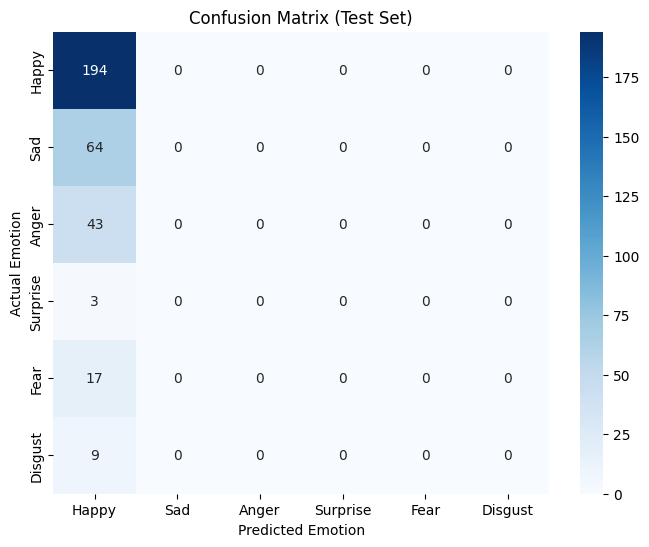

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


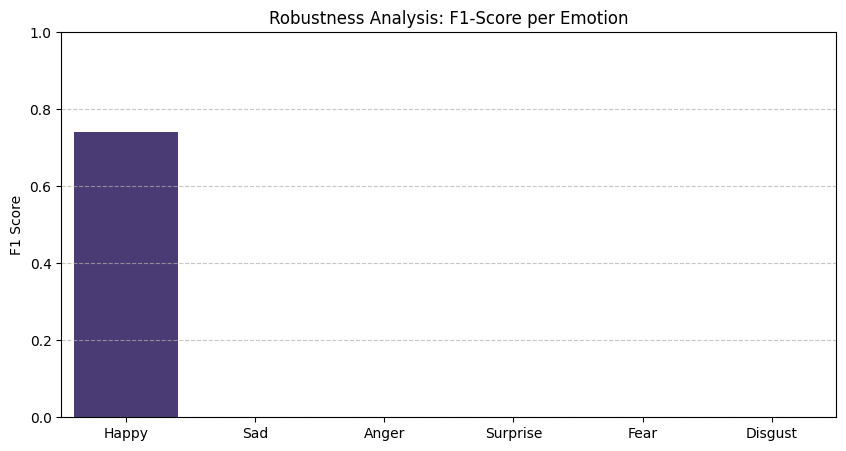

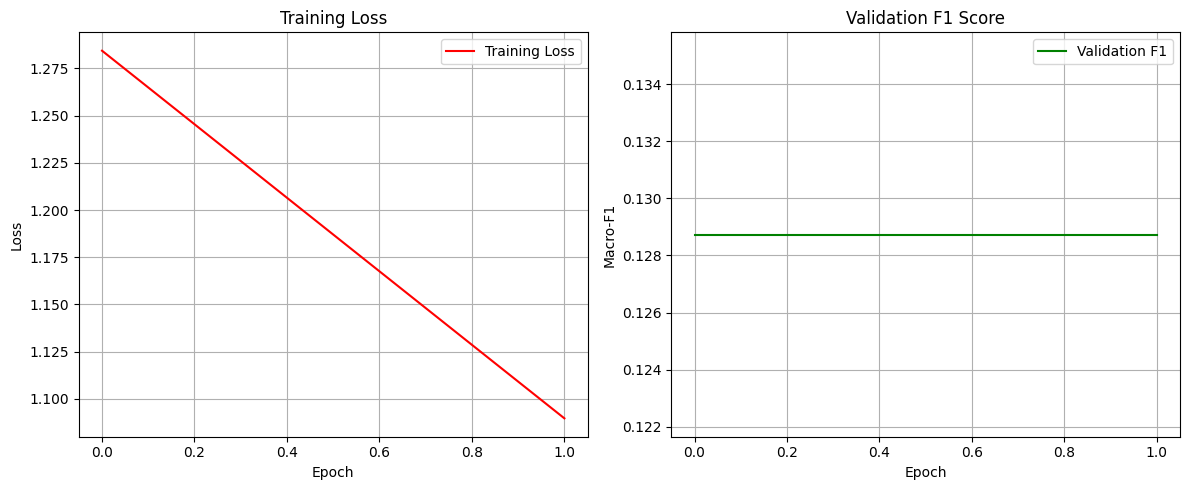

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Define Emotion Labels for the charts
emotions = ['Happy', 'Sad', 'Anger', 'Surprise', 'Fear', 'Disgust']

# 1. Classification Report (The detailed numbers)
print("\n--- 📝 Detailed Classification Report ---")
print(classification_report(test_targets, test_preds, target_names=emotions))

# 2. Confusion Matrix (The Heatmap)
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# 3. Class-wise F1 Bar Chart (The Comparison)
f1_scores = f1_score(test_targets, test_preds, average=None)
plt.figure(figsize=(10, 5))
sns.barplot(x=emotions, y=f1_scores, palette='viridis')
plt.title('Robustness Analysis: F1-Score per Emotion')
plt.ylabel('F1 Score')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Learning Curves (The Stability Check)
if len(history['loss']) > 0:
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss', color='red')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Validation F1', color='green')
    plt.title('Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Macro-F1')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [23]:
import os
file_name = "emotiwave_best.pth"

if os.path.exists(file_name):
    size_bytes = os.path.getsize(file_name)
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ CONFIRMED: Model file '{file_name}' exists.")
    print(f"   Size: {size_mb:.2f} MB")
else:
    print(f"❌ ERROR: File {file_name} not found. Please re-run the training cell.")

✅ CONFIRMED: Model file 'emotiwave_best.pth' exists.
   Size: 6.15 MB
